Train data shape: (15308, 23)
Test data shape: (914, 23)

Missing values in training data:
row_id                             0
agent_code                         0
agent_age                          0
agent_join_month                   0
first_policy_sold_month            0
year_month                         0
unique_proposals_last_7_days       0
unique_proposals_last_15_days      0
unique_proposals_last_21_days      0
unique_proposal                    0
unique_quotations_last_7_days      0
unique_quotations_last_15_days     0
unique_quotations_last_21_days     0
unique_quotations                  0
unique_customers_last_7_days       0
unique_customers_last_15_days      0
unique_customers_last_21_days      0
unique_customers                   0
new_policy_count                   0
ANBP_value                         0
net_income                         0
number_of_policy_holders           0
number_of_cash_payment_policies    0
dtype: int64

Summary statistics of training data:
       

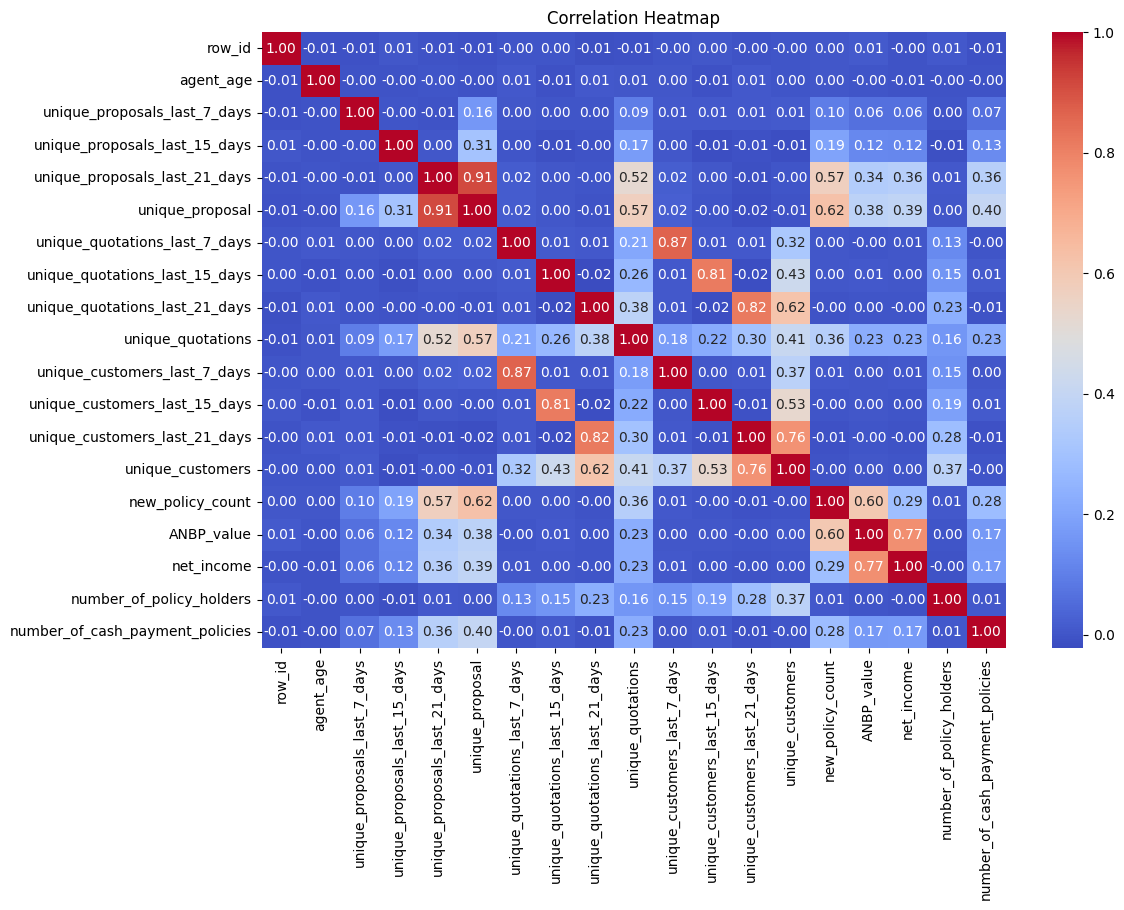

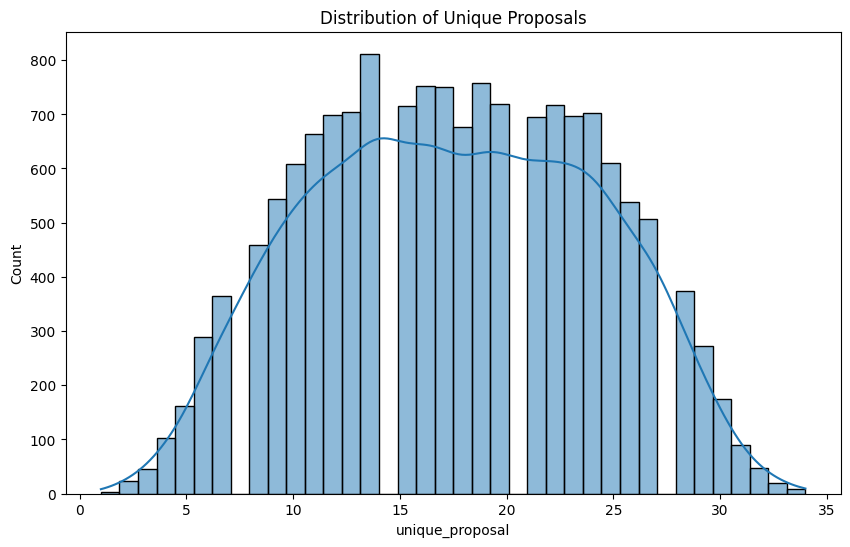

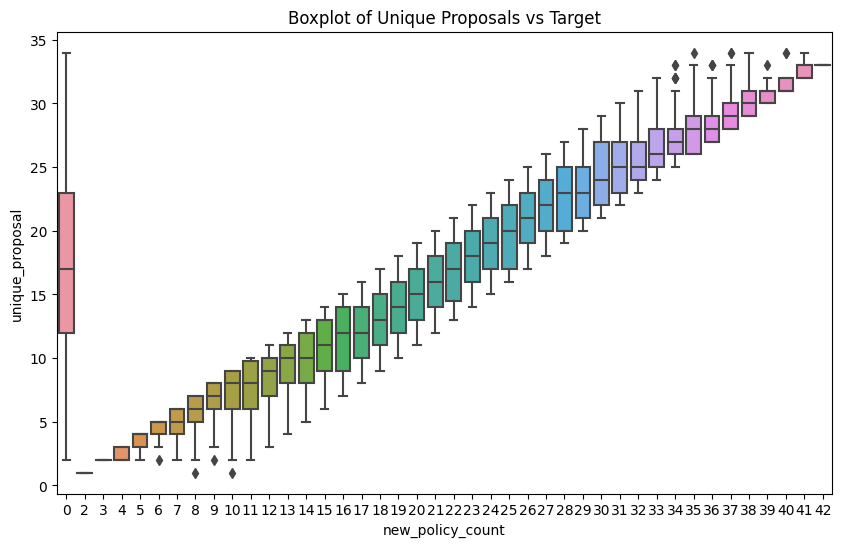

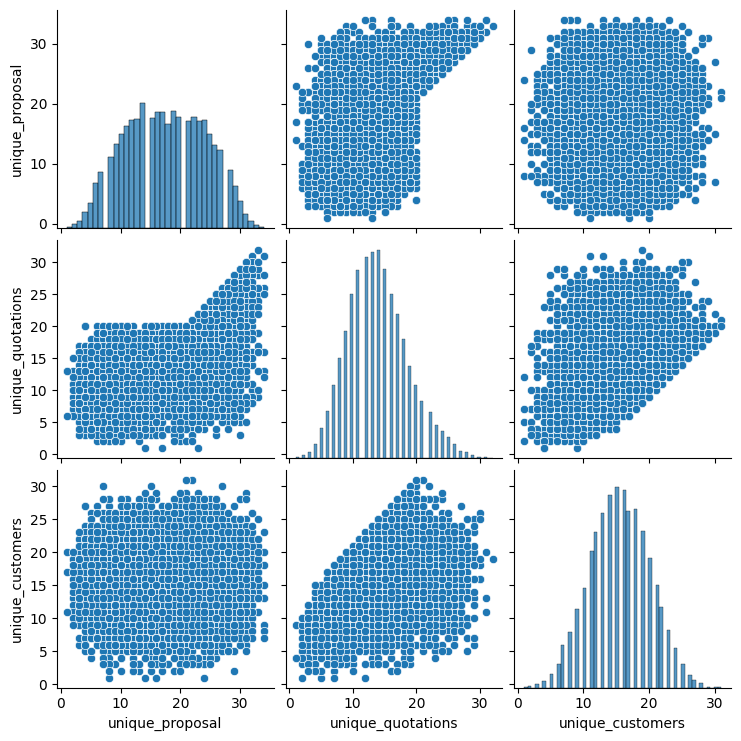

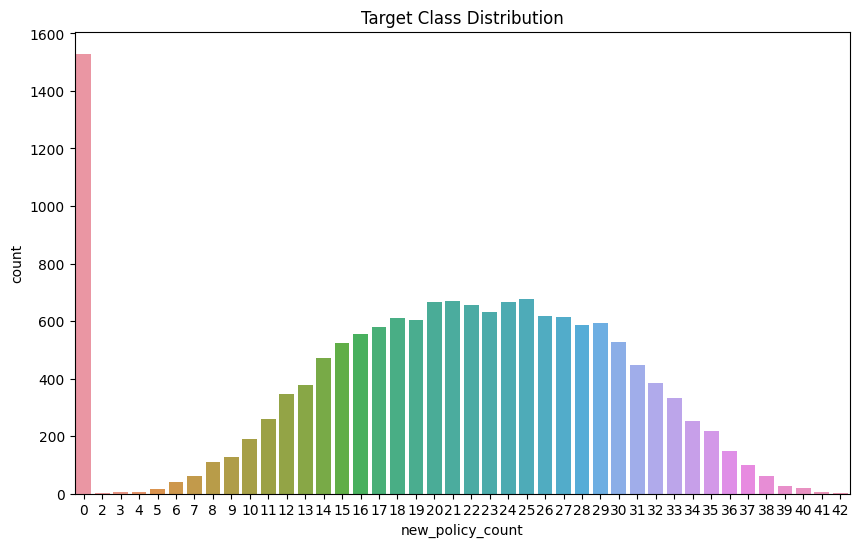

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[0]	validation_0-logloss:0.34213	validation_1-logloss:0.34226
[99]	validation_0-logloss:0.00930	validation_1-logloss:0.01081

Model Evaluation:
Accuracy: 0.9984
Precision: 0.9993
Recall: 0.9989
F1 Score: 0.9991
ROC AUC: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       306
           1       1.00      1.00      1.00      2756

    accuracy                           1.00      3062
   macro avg       0.99      1.00      1.00      3062
weighted avg       1.00      1.00      1.00      3062


Submission file created: xgboost_submission.csv


<Figure size 1200x800 with 0 Axes>

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Load data
train_data = pd.read_csv('/kaggle/input/data-storm-6-0/train_storming_round.csv')
test_data = pd.read_csv('/kaggle/input/data-storm-6-0/test_storming_round.csv')

# Check shapes
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

# Target column creation
def create_target(df):
    if 'new_policy_count' in df.columns:
        return np.where(df['new_policy_count'] == 0, 0, 1)
    return None

# Create target for training data
target = create_target(train_data)

# Data preprocessing function
def preprocess_data(df, is_training=True):
    processed_df = df.copy()
    date_columns = ['agent_join_month', 'first_policy_sold_month', 'year_month']
    for col in date_columns:
        if col in processed_df.columns:
            processed_df[col] = pd.to_datetime(processed_df[col])
    
    processed_df['agent_experience_months'] = ((processed_df['year_month'].dt.year - processed_df['agent_join_month'].dt.year) * 12 + 
                                                (processed_df['year_month'].dt.month - processed_df['agent_join_month'].dt.month))
    processed_df['months_since_first_policy'] = np.where(pd.notnull(processed_df['first_policy_sold_month']),
                                                         ((processed_df['year_month'].dt.year - processed_df['first_policy_sold_month'].dt.year) * 12 + 
                                                          (processed_df['year_month'].dt.month - processed_df['first_policy_sold_month'].dt.month)),
                                                         -1)
    
    processed_df['current_month'] = processed_df['year_month'].dt.month
    processed_df['current_year'] = processed_df['year_month'].dt.year
    processed_df['join_month'] = processed_df['agent_join_month'].dt.month
    processed_df['join_year'] = processed_df['agent_join_month'].dt.year
    
    processed_df['proposal_to_quotation_ratio'] = processed_df['unique_proposal'] / (processed_df['unique_quotations'] + 1)
    processed_df['quotation_to_customer_ratio'] = processed_df['unique_quotations'] / (processed_df['unique_customers'] + 1)
    
    if 'number_of_policy_holders' in processed_df.columns:
        processed_df['cash_payment_ratio'] = processed_df['number_of_cash_payment_policies'] / (processed_df['number_of_policy_holders'] + 1)
    
    processed_df['proposal_decline_7_15'] = processed_df['unique_proposals_last_7_days'] - processed_df['unique_proposals_last_15_days']
    processed_df['proposal_decline_15_21'] = processed_df['unique_proposals_last_15_days'] - processed_df['unique_proposals_last_21_days']
    processed_df['quotation_decline_7_15'] = processed_df['unique_quotations_last_7_days'] - processed_df['unique_quotations_last_15_days']
    processed_df['quotation_decline_15_21'] = processed_df['unique_quotations_last_15_days'] - processed_df['unique_quotations_last_21_days']
    processed_df['customer_decline_7_15'] = processed_df['unique_customers_last_7_days'] - processed_df['unique_customers_last_15_days']
    processed_df['customer_decline_15_21'] = processed_df['unique_customers_last_15_days'] - processed_df['unique_customers_last_21_days']
    
    drop_cols = ['agent_join_month', 'first_policy_sold_month', 'year_month']
    
    if 'new_policy_count' in processed_df.columns:
        drop_cols.append('new_policy_count')
    
    processed_df = processed_df.drop(columns=drop_cols, errors='ignore')
    
    return processed_df

# Preprocess train and test data
train_processed = preprocess_data(train_data)
test_processed = preprocess_data(test_data, is_training=False)

# Define features and target
X = train_processed.drop(['row_id', 'agent_code'], axis=1, errors='ignore')
y = target

# Split the data for training and validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# EDA Steps

## Check for missing values
print("\nMissing values in training data:")
print(train_data.isnull().sum())

## Summary statistics of numerical features
print("\nSummary statistics of training data:")
print(train_data.describe())

## Check target class distribution
print("\nTarget class distribution:")
print(train_data['new_policy_count'].value_counts())

## Correlation heatmap (only numeric columns)
numeric_cols = train_data.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(12, 8))
sns.heatmap(train_data[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

## Distribution of unique proposals
plt.figure(figsize=(10, 6))
sns.histplot(train_data['unique_proposal'], kde=True)
plt.title('Distribution of Unique Proposals')
plt.show()

## Boxplot for outliers (Unique Proposals vs Target)
plt.figure(figsize=(10, 6))
sns.boxplot(x='new_policy_count', y='unique_proposal', data=train_data)
plt.title('Boxplot of Unique Proposals vs Target')
plt.show()

## Pairplot of key features
sns.pairplot(train_data[['unique_proposal', 'unique_quotations', 'unique_customers']])
plt.show()

## Categorical feature analysis - Target class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='new_policy_count', data=train_data)
plt.title('Target Class Distribution')
plt.show()

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize XGBoost model
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Hyperparameter tuning with GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=1, scoring='f1')
grid_search.fit(X_train, y_train)

# Get the best model from GridSearchCV
xgb_model = grid_search.best_estimator_

# Train the model with early stopping
xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=100, early_stopping_rounds=20)

# Make predictions on the validation set
y_pred_proba = xgb_model.predict_proba(X_valid)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

# Print evaluation metrics
print("\nModel Evaluation:")
print(f"Accuracy: {accuracy_score(y_valid, y_pred):.4f}")
print(f"Precision: {precision_score(y_valid, y_pred):.4f}")
print(f"Recall: {recall_score(y_valid, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_valid, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_valid, y_pred_proba):.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_valid, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_valid, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('confusion_matrix.png')
plt.close()

# Plot ROC curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_valid, y_pred_proba)
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc_score(y_valid, y_pred_proba):.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')
plt.close()

# Plot feature importance
plt.figure(figsize=(12, 8))
xgb.plot_importance(xgb_model, max_num_features=20, height=0.5)
plt.title('XGBoost Feature Importance')
plt.savefig('feature_importance.png')
plt.close()

# Prepare test data for prediction
X_test = test_processed.drop(['row_id', 'agent_code'], axis=1, errors='ignore')
X_test_scaled = scaler.transform(X_test)

# Make predictions on test data
test_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
test_pred = (test_pred_proba >= 0.5).astype(int)

# Create submission file
submission = pd.DataFrame({
    'row_id': test_data['row_id'],
    'target_column': test_pred
})

# Save submission file
submission.to_csv('xgboost_submission.csv', index=False)
print("\nSubmission file created: xgboost_submission.csv")
